In [1]:
# Kaggle
# https://www.kaggle.com/docstein/brics-world-bank-indicators
# https://www.kaggle.com/worldbank/world-development-indicators?select=Indicators.csv

# Resources
# https://datahelpdesk.worldbank.org/knowledgebase/articles/906531-methodologies

In [1]:
!pip install dtaidistance
!pip install pyclustering

import os
import zipfile
import numpy as np
import pandas as pd
import pyclustering
import dtaidistance
import seaborn as sns 
from fastdtw import fastdtw
from sklearn import manifold  
import matplotlib.pyplot as plt
import statsmodels.tsa.vector_ar
from statsmodels.tsa.api import VAR
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import AgglomerativeClustering
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import euclidean, squareform
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pyclustering.cluster import cluster_visualizer_multidim
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [2]:
from statsmodels.tsa.arima_model import ARIMA

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
os.environ['KAGGLE_USERNAME'] = "cubicsrube" # username from the json file
os.environ['KAGGLE_KEY'] = "6e2367734120e39c492cbf125549e6ca" # key from the json file
!kaggle datasets download -d worldbank/world-development-indicators # api copied from kaggle

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


EXRACT FILE

In [5]:
with zipfile.ZipFile('/content/world-development-indicators.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

FileNotFoundError: [Errno 2] No such file or directory: '/content/world-development-indicators.zip'

IMPORT DATAFRAMES

In [6]:
# series_df = pd.read_csv("/content/data/Series.csv", sep=",")
# country_df = pd.read_csv("/content/data/Country.csv", sep=",")
# indicators_df = pd.read_csv("/content/data/Indicators.csv", sep=",")
# country_notes_df = pd.read_csv("/content/data/CountryNotes.csv", sep=",")
indicators_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\Indicators.csv", sep=",")
country_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\Country.csv", sep=",")
country_notes_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\CountryNotes.csv", sep=",")
series_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\Series.csv", sep=",")

FILER DATA FROM COUNTRIES THAT ONLY USED THE 2008 SYSTEM OF NATIONAL ACCOUNTS METHODOLOGY

In [8]:
# Country filters ['SystemOfNationalAccounts']
# - Country uses the 1968 System of National Accounts methodology.
# - Country uses the 1993 System of National Accounts methodology.
# - Country uses the 2008 System of National Accounts methodology.
countries = country_df[country_df['SystemOfNationalAccounts']=='Country uses the 2008 System of National Accounts methodology.'].reset_index()
# 
country_codes = list(countries['CountryCode'])
# todo: drop argentina

DATA CLEANING

Import DataFrames

In [9]:
indicators_countries =indicators_df
col_filtered = indicators_countries[["IndicatorCode","CountryCode","Year","Value"]]
years = list(col_filtered["Year"].unique())
ind_codes = list(col_filtered["IndicatorCode"].unique())
full_data = list(indicators_countries["IndicatorCode"].unique())
len(ind_codes) #determine the total number of indicators

1344

Create Function to fill all countries with all possible indicators. NA values 
will be filled in cells where indicator is not measured for the particular country that year.

In [10]:
def get_tbl_full_year(country_code,year):
  #determine the unique indicators which exist for a particular country
  df2 = col_filtered[col_filtered["CountryCode"] == country_code]

  #get all indicators for a particular year
  ind_dicts = list(map(lambda x: get_ind_dict(df2,x), year))

  #create dictionary for all indicators for all years
  ind_dicts = list(map(lambda x: create_dict(x), ind_dicts))
  return (ind_dicts)

def get_ind_dict(df2,year):
  #get all the indicators measured for a particular year
  df3 = df2[df2["Year"] == year][["IndicatorCode","Value"]]
  df3.set_index("IndicatorCode",inplace=True)
  df3 =  df3.transpose()
  ind_dict = dict(df3)
  ind_dict = create_dict(ind_dict)
  return (ind_dict)
  
def create_dict(ind_dict): 
  #create dictionary pairing indicators and their readings for that year
  for key in ind_dict:
    try:
      ind_dict[key] = ind_dict[key][0]
    except (IndexError, TypeError):
      pass
  absent_bool = list(map(lambda x: x not in ind_dict, full_data))
  absent_array = np.array(full_data)[np.array(absent_bool)]
  absent_dict = {}
  for i in range(len(absent_array)):
    absent_dict.update({absent_array[i]:np.nan})
  ind_dict.update(absent_dict)
  return (ind_dict)

In [11]:
def fn(index, from_year, to_year):
  n_years = to_year - from_year
  a = get_tbl_full_year(country_codes[index], list(range(from_year, to_year)))
  a = pd.DataFrame(a)
  a.index = [np.tile(country_codes[index], to_year - from_year), np.arange(from_year, to_year, 1)]
  return a

# processed_attributes = pd.DataFrame(dict()) #fn(0, 2008, 2016)
def create_df(max_na, threshold, from_year, to_year):
  # add country codes with a maximum of max_na(fraction) NaN cells.
  processed_attributes = None
  n_years = to_year - from_year
  for i in range(0, len(country_codes)):
    temp = fn(i, from_year, to_year)
    perc = 1 - temp.applymap(lambda x: pd.isna(x)).sum().sum() / np.prod(temp.shape)
    # percentage of non_na cells
    if perc > max_na:
      print(f"Adding {country_codes[i]} {perc}")
      if processed_attributes is None:
        processed_attributes = temp
      else:
        processed_attributes = pd.concat([processed_attributes, temp], axis=0)
    else:
      print(f"Skipping {country_codes[i]} {perc}")
  processed_attributes.dropna(thresh=(threshold*len(processed_attributes.index)), axis=1, inplace=True)
  return (processed_attributes, n_years)

In [12]:
processed_attributes , n_years= create_df(0.3, 0.99, 1990,2015)

Adding ARG 0.4833035714285714
Adding AUS 0.4632440476190476
Adding AUT 0.4811607142857143
Adding BEL 0.463125
Adding CAN 0.4529761904761904
Adding CZE 0.49872023809523813
Adding DNK 0.4911011904761905
Adding ECU 0.6455654761904762
Adding EST 0.45895833333333336
Adding FIN 0.4933630952380952
Adding FRA 0.48684523809523805
Adding DEU 0.4795238095238096
Adding GRC 0.47627976190476196
Adding HKG 0.38592261904761904
Adding HUN 0.5111011904761904
Adding ISL 0.4392559523809524
Adding IND 0.6361309523809524
Adding IRL 0.47901785714285716
Adding ISR 0.43875
Adding ITA 0.4899404761904762
Adding KOR 0.5043154761904762
Adding LVA 0.45116071428571425
Adding LTU 0.4419047619047619
Adding LUX 0.41770833333333335
Adding MEX 0.6895238095238095
Adding NLD 0.4805952380952381
Adding NZL 0.43675595238095233
Adding NGA 0.5913690476190476
Adding NOR 0.47413690476190473
Adding POL 0.4951488095238096
Adding PRT 0.4770833333333333
Adding RWA 0.5667559523809524
Adding SGP 0.4202678571428572
Adding SVK 0.46220238

OBTAIN SUMMARY OF RESULTANT DATAFRAME

In [15]:
total_values = processed_attributes.count().sum()
total_values_na = processed_attributes.applymap(lambda x: pd.isna(x)).sum().sum()
print(f"Total: {total_values + total_values_na}, Values: {total_values}, NA: {total_values_na}")

Total: 40700, Values: 40680, NA: 20


DETERMINE NUMBER OF COUNTRIES REMAINING

In [16]:
#processed_attributes.to_csv('/content/data.csv')
filtered_series = series_df[series_df['SeriesCode'].isin(processed_attributes.columns)]
#filtered_series.to_csv('/content/data.csv')
print(f"There are {len(processed_attributes.index)/n_years} countries left")

There are 44.0 countries left


GET LIST OF ALL COUNTRIES REMAINING FOR LATER USE

In [17]:
def get_country_list(processed_attributes):
  country_set = set((processed_attributes.index).map(lambda x: x[0]))
  country_list = list(country_set)
  country_list.sort()
  return country_list
country_list = get_country_list(processed_attributes)

INTERPOLATE AND IMPUTE WHERE INTERPOLATION DID NOT WORK

In [18]:
def impute(processed_attributes,index):
  df_cum = processed_attributes[(processed_attributes.index).map(lambda x: x[0] == country_list[index])]
  nan_cols = [i for i in df_cum.columns if df_cum[i].isnull().all()]
  for colname in nan_cols:
    df_cum[[colname]] = 0;
  imputed_data = df_cum.apply(lambda x:x.interpolate(method='linear'))
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy = True)
  imputed_data = pd.DataFrame(imp_mean.fit_transform(imputed_data))
  imputed_data.columns = df_cum.columns
  #data1 = data1.fillna(method='ffill')
  return imputed_data #pd.DataFrame(imputed_data, columns = df_cum.columns)

In [19]:
def impute_a(processed_attributes, rng):
  return list(map(lambda x: impute(processed_attributes, x),rng))
a = impute_a(processed_attributes, range(0,len(country_list)))

In [20]:
data_final = pd.concat(a)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_final)
data_scaled = pd.DataFrame(data_scaled, columns=data_final.columns)
inds = data_scaled.columns

In [21]:
def corrmat(abs=False):
  f = plt.figure(figsize=(30, 15))
  if abs == True:
    plt.matshow(np.abs(data_scaled.corr()), fignum=f.number)
  else:
    plt.matshow(data_scaled.corr(), fignum=f.number)
  plt.xticks(range(data_scaled.shape[1]), inds, fontsize=10, rotation=90)
  plt.yticks(range(data_scaled.shape[1]), inds, fontsize=10)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=10)

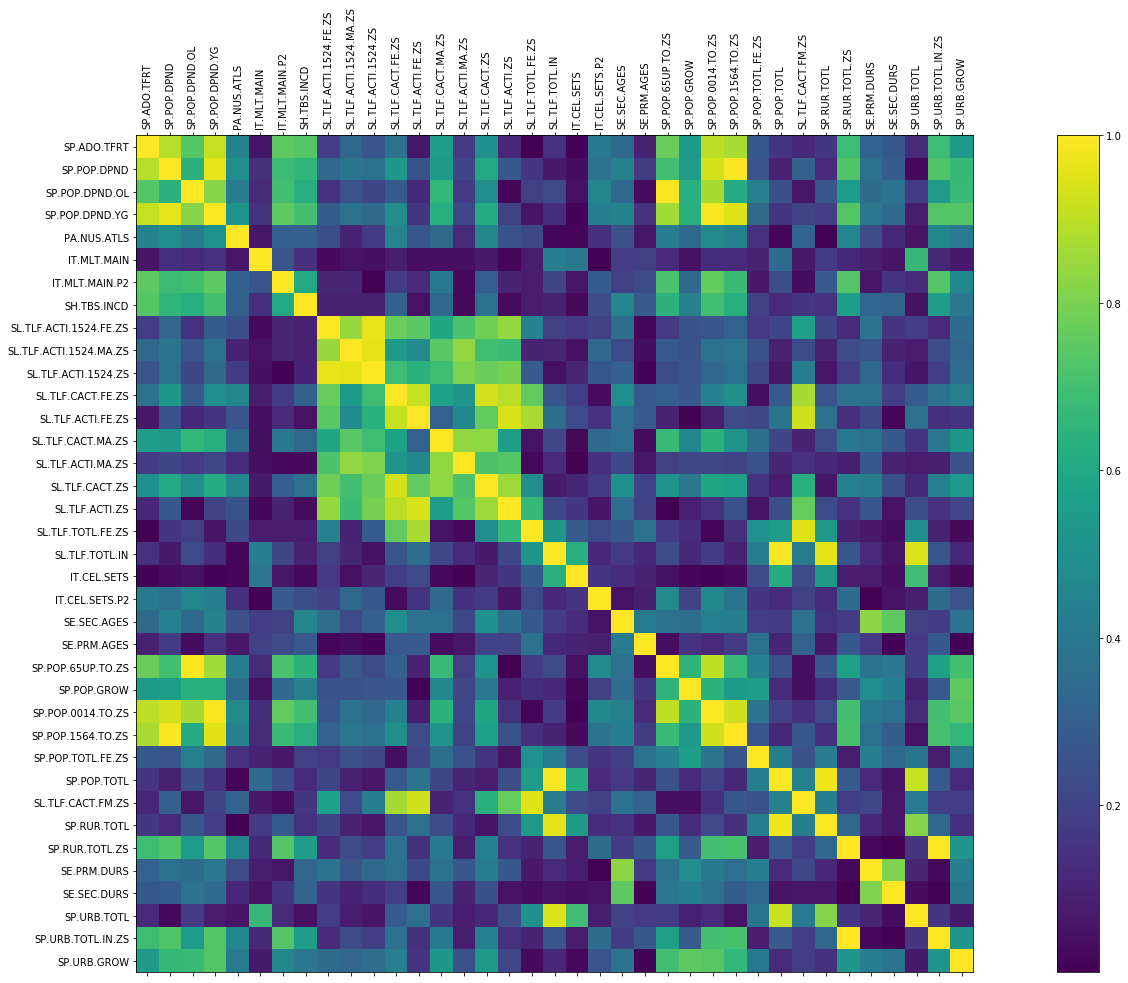

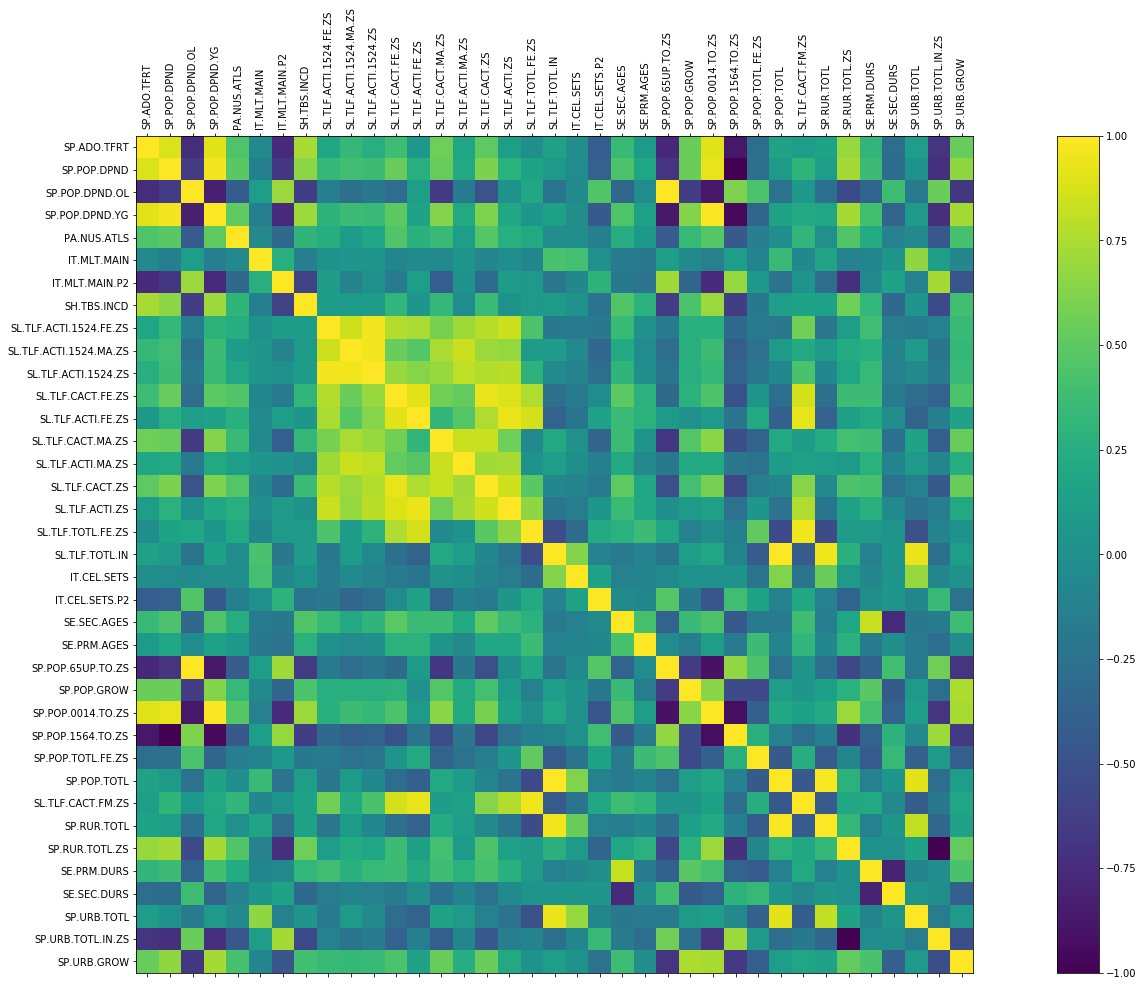

In [22]:
corrmat(abs = True);
corrmat(abs = False);

In [23]:
pcamodel = PCA(n_components=10)
pca = pcamodel.fit_transform(data_scaled)

In [24]:
print(f"{n_years} years are under consideration")

25 years are under consideration


In [25]:
summary_df = pd.DataFrame([pcamodel.explained_variance_ , pcamodel.explained_variance_ratio_]).transpose()
summary_df.columns = ["explained_variance","explained_variance_ratio"]
summary_df

,explained_variance,explained_variance_ratio
0,13.046160,0.352278
1,7.549224,0.203848
2,4.176577,0.112778
3,2.954278,0.079773
4,1.993378,0.053826
5,1.308509,0.035333
6,1.006588,0.027180
7,0.774176,0.020905
8,0.692809,0.018708
9,0.624541,0.016864


## explained variance plot

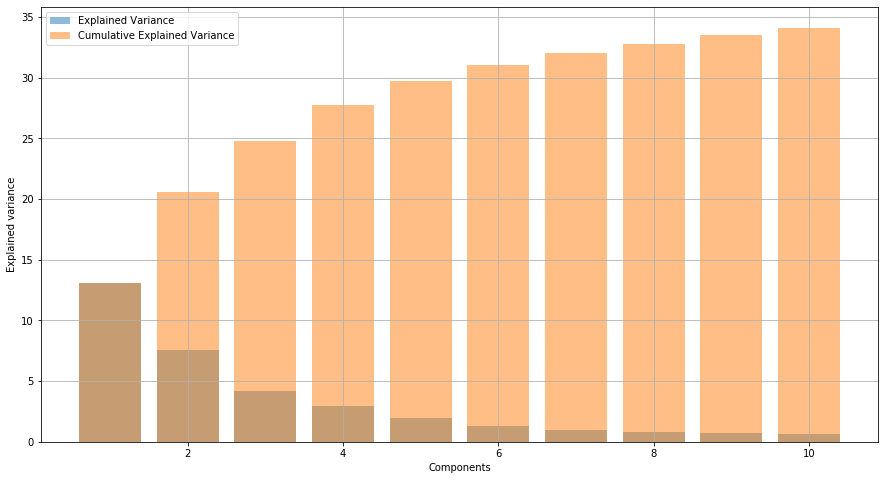

In [26]:
plt.figure(figsize=(15,8))

plt.bar(range(1,len(pcamodel.explained_variance_ )+1),
        pcamodel.explained_variance_,
        label="Explained Variance", alpha = 0.5)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.bar(range(1,len(pcamodel.explained_variance_ )+1),
         np.cumsum(pcamodel.explained_variance_),
         label="Cumulative Explained Variance", alpha = 0.5)
plt.legend(loc='upper left')
plt.grid()

### explained variance ratio plot

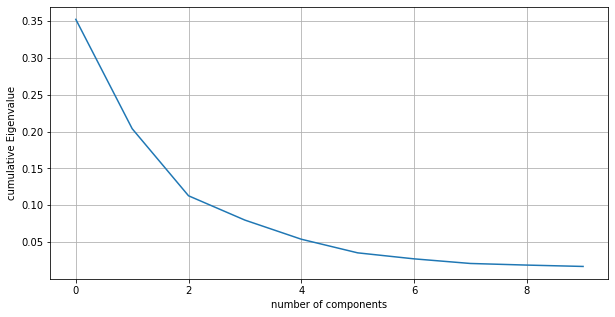

In [27]:
plt.figure(figsize=(10,5))
plt.plot(pcamodel.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative Eigenvalue')
plt.grid()
plt.show()

### scree plot

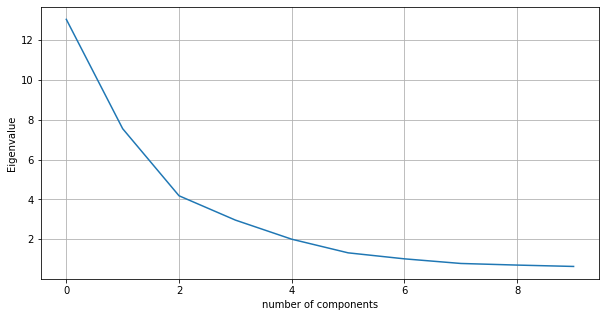

In [28]:
plt.figure(figsize=(10,5))
plt.axis
plt.plot(pcamodel.explained_variance_)
plt.xlabel('number of components',)
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [29]:
pcamodel.explained_variance_

array([13.04616037,  7.54922392,  4.17657712,  2.95427795,  1.99337796,
        1.30850867,  1.00658751,  0.77417555,  0.69280901,  0.6245406 ])

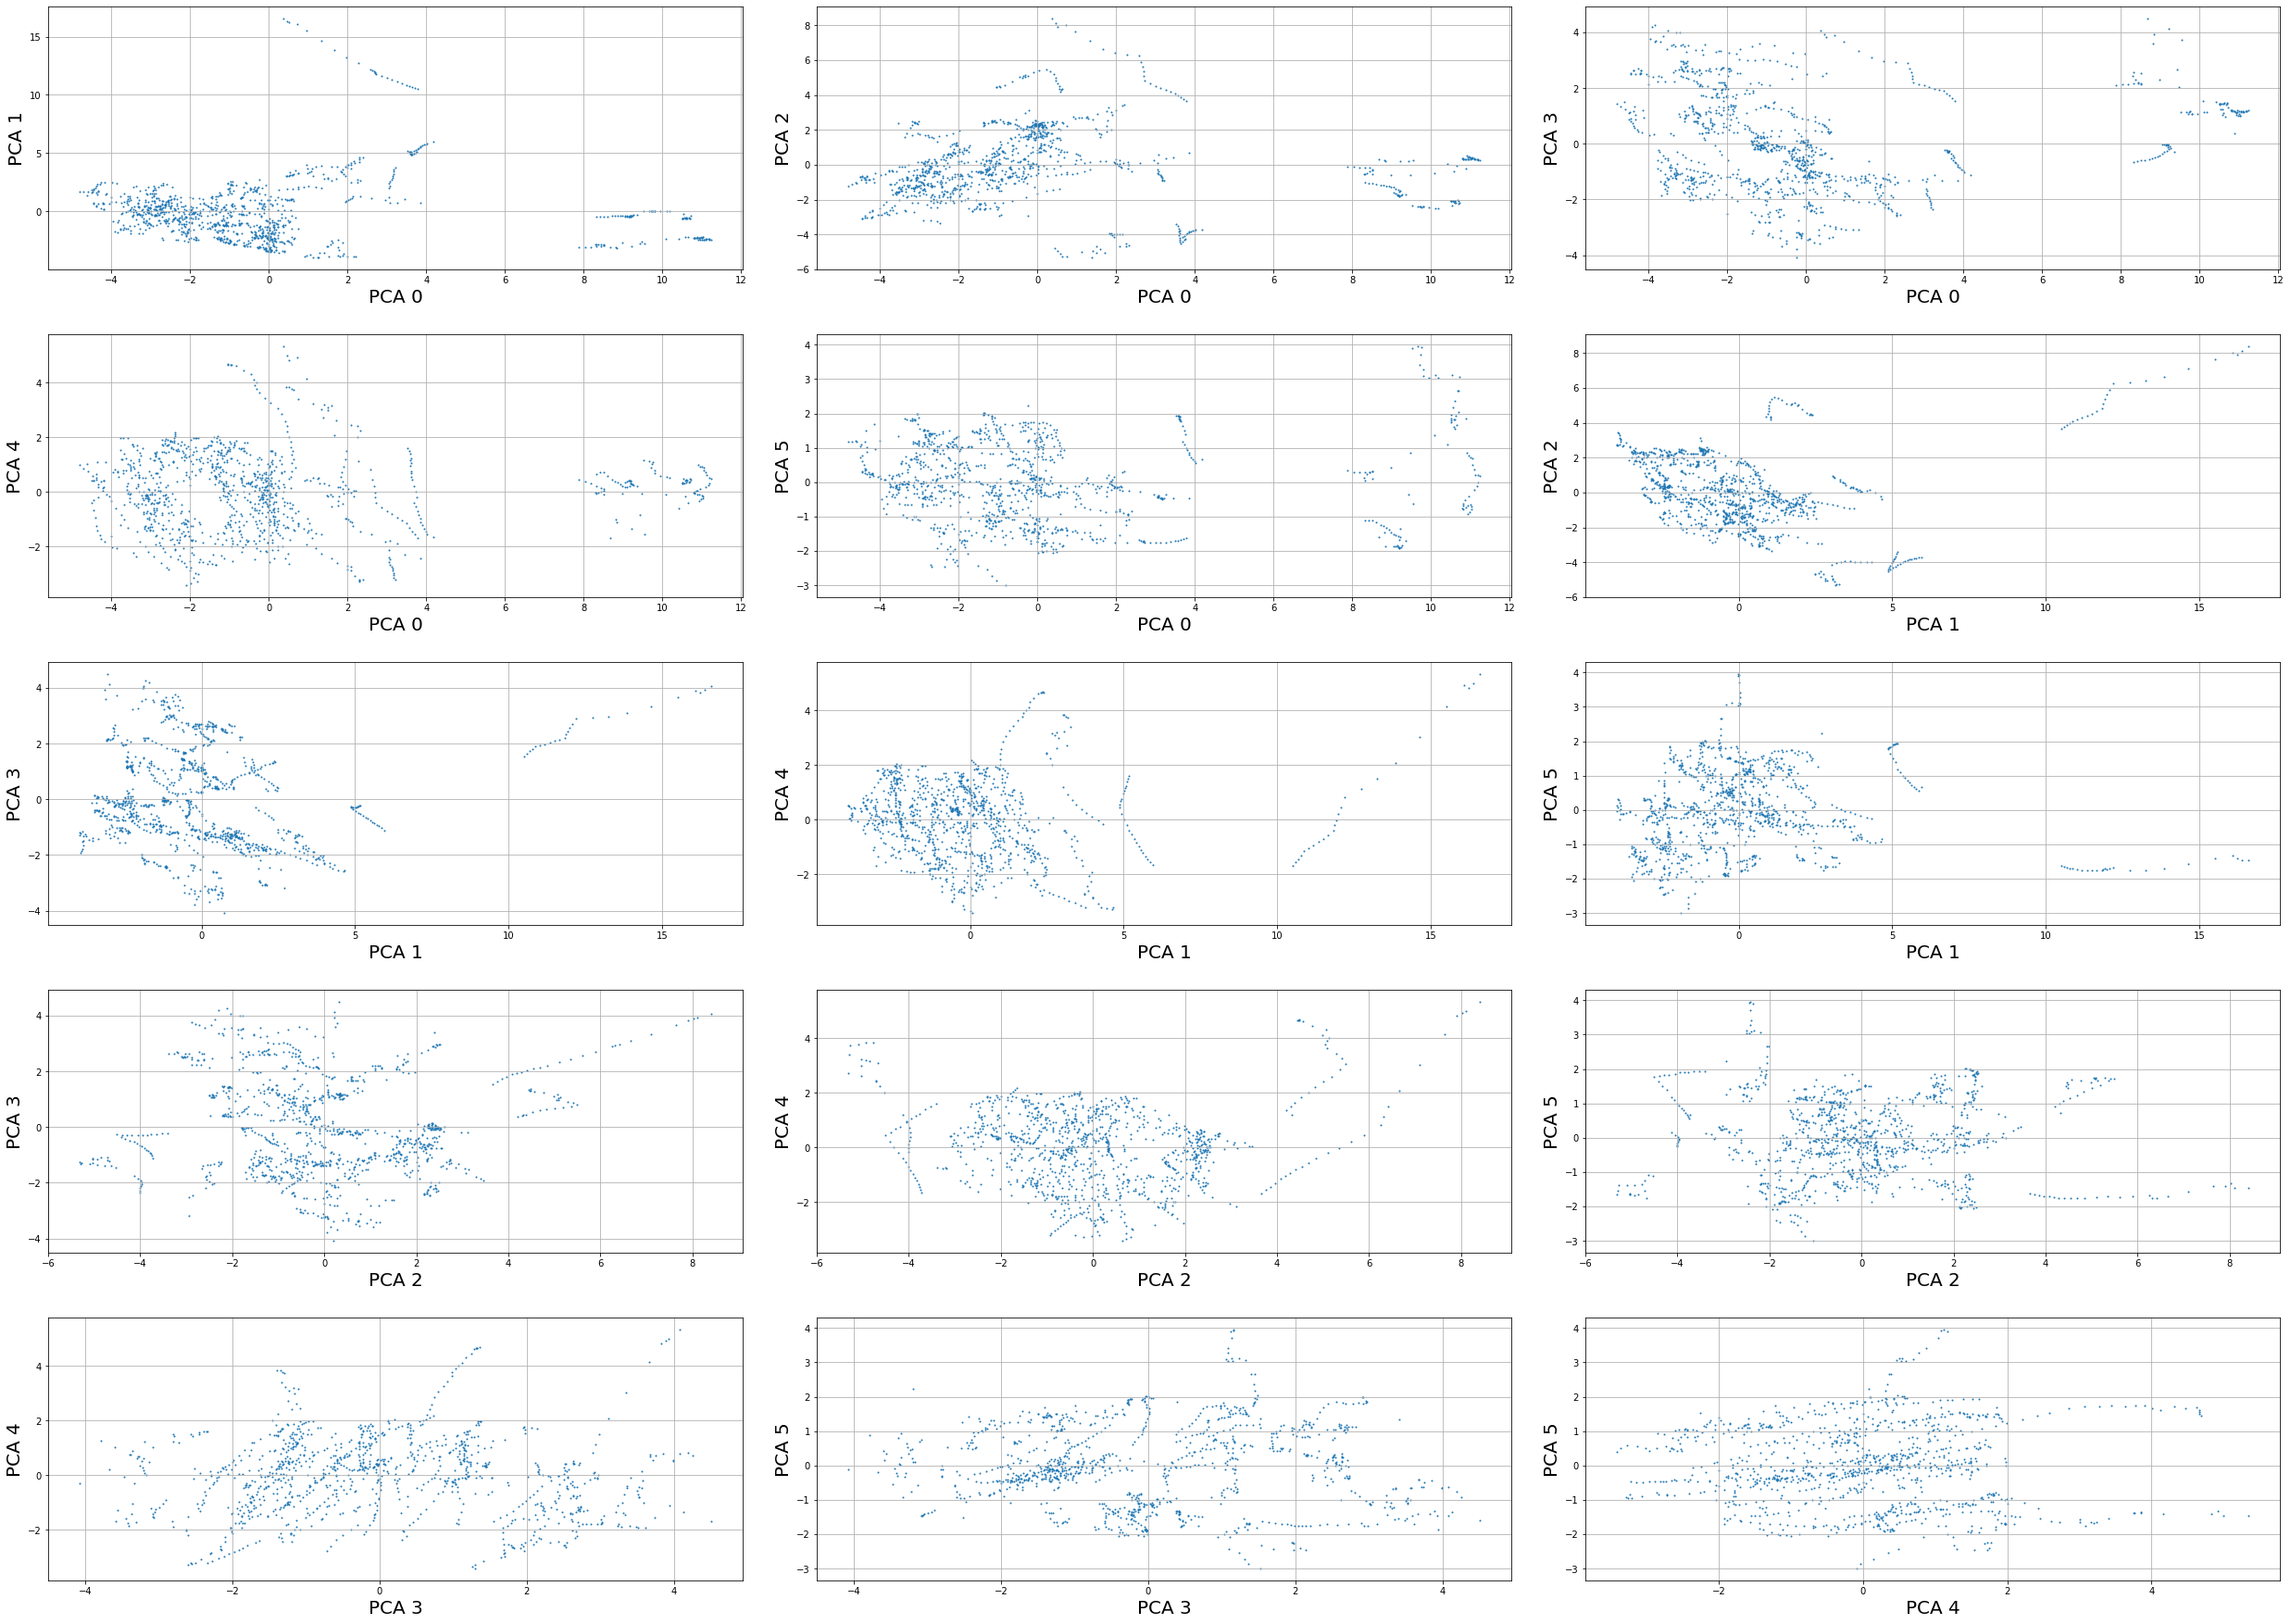

In [30]:
z = 0
n=0
fig, axs = plt.subplots(5, 3, figsize = (35,25))
for i in range(0,6):
  for j in range(i+1,6):
    axs[n,z].scatter(pca[:, i], pca[:, j], s = 1)
    axs[n,z].set_xlabel(f"PCA {i}", fontsize = 20)
    axs[n,z].set_ylabel(f"PCA {j}", fontsize = 20)
    axs[n,z].grid()
    z += 1
    if z % 3 == 0:
      n += 1
      z = 0
fig.tight_layout(pad=3.0)

## effect of variables on each component

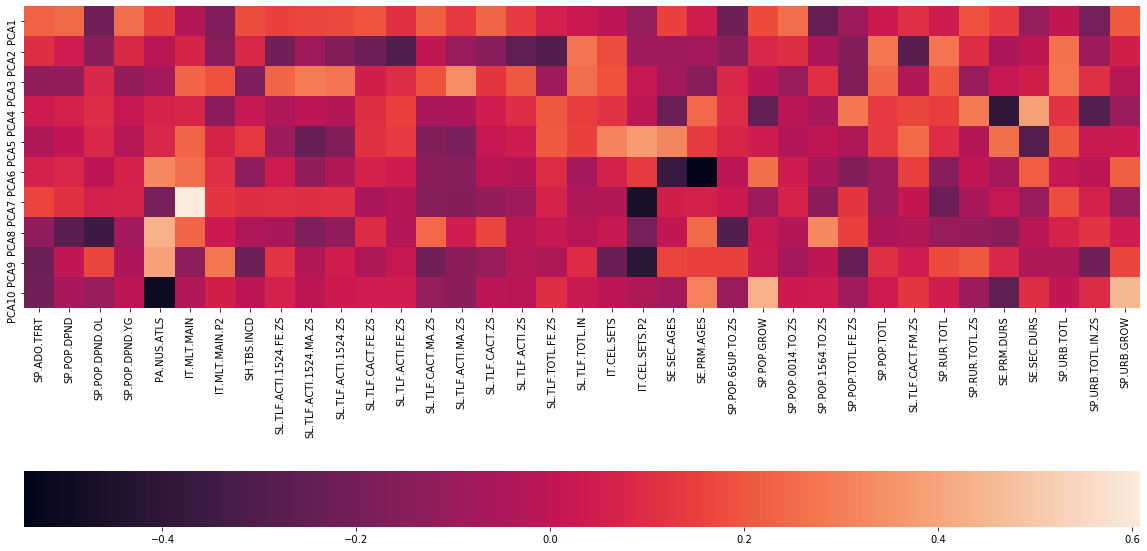

In [31]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(pcamodel.components_,
                 yticklabels=[ "PCA"+str(data_scaled) for data_scaled in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(data_scaled.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

<prev>
    Taking into place the first 6 PCA's, the top 4 variables with the most influence in these components are:
    
    PCA 1
    -SP.POP.0014.TO.ZS
    -SP.POP.DPND.YG
    -SP.POP.DPND
    -SP.ADO.TFRT
    
    PCA 2
    -SL.TLF.TOTL.IN
    -SP.POP.TOTL
    -SP.RUR.TOTL
    -SP.URB.TOTL
    
    PCA 3
    -SL.TLF.ACTI.MA.ZS
    -LTLF,ACTI.1524.ZS
    -SL.TLF.CACT.FE.ZS
    -SP.URB.TOTL
    
    PCA 4
    -SE.SEC.DURS
    -SP.RUR.TOTL.ZS
    -SP.POP.TOTL.FE.ZS
    -SE.PRM.AGES
    
    PCA 5
    -IT.CEL.SETS.P2
    -SE.SEC.AGES
    -IT.CEL.SETS.P2
    -SE.PRM.DURS
    
    PCA 6
    -PA.NUS.ATLS
    -SP.POP.GROW
    -SE.SEC.DURS
    -SP.URB.GROW
    
<prev/>

## Biplot

In [32]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(15,15))
    plt.scatter(xs * scalex,ys * scaley,s=5)
    
    results = []
    
    for i in range(n):
        arrow_color = 'g'
       
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
        if abs(coeff[i,0]) > 0.2 and abs(coeff[i,1]) > 0:
            #print(labels[i])
            results.append(labels[i])
            #arrow_color = 'b'
         
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color =  arrow_color,alpha = 0.5)

 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    return results

influential_attributes = []

[['SP.ADO.TFRT', 'SP.POP.DPND', 'SP.POP.DPND.OL', 'SP.POP.DPND.YG', 'SL.TLF.CACT.MA.ZS', 'SL.TLF.CACT.ZS', 'SP.POP.65UP.TO.ZS', 'SP.POP.0014.TO.ZS', 'SP.POP.1564.TO.ZS', 'SP.URB.GROW']]


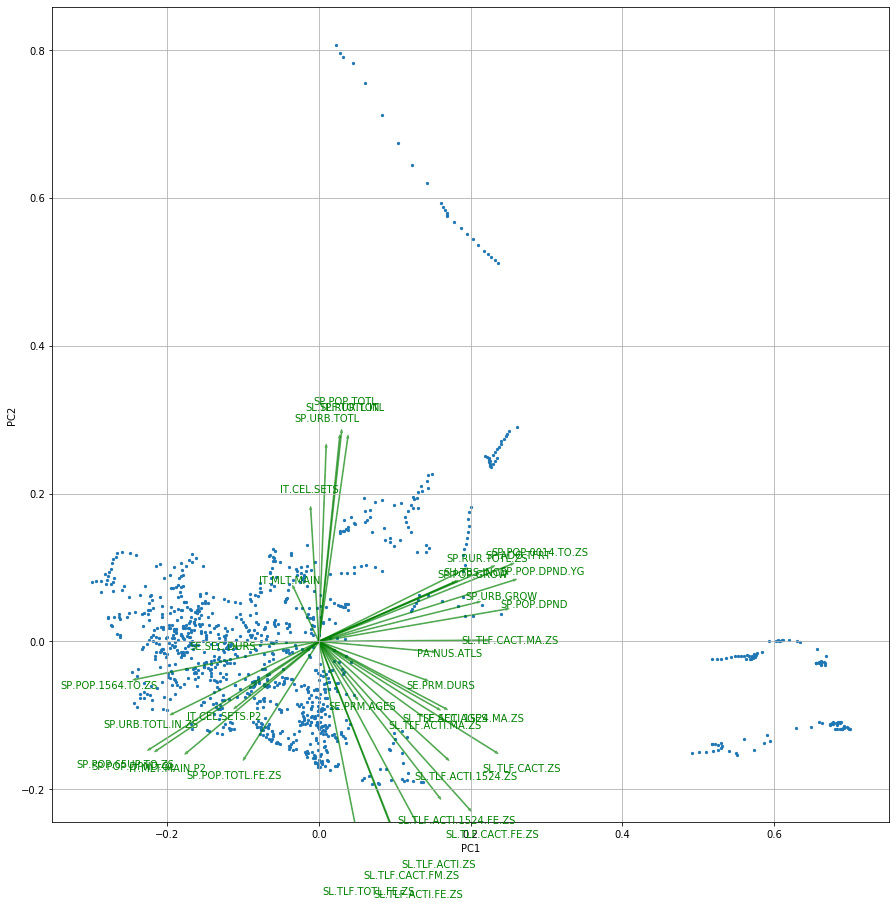

In [33]:
temp = myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(data_scaled.columns))
influential_attributes.append(temp)
print(influential_attributes)

In [34]:
indicators_df[indicators_df['IndicatorCode'].isin(influential_attributes[0])]["IndicatorName"].unique()

array(['Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old (% of working-age population)',
       'Age dependency ratio, young (% of working-age population)',
       'Population ages 65 and above (% of total)',
       'Population, ages 0-14 (% of total)',
       'Population, ages 15-64 (% of total)',
       'Urban population growth (annual %)',
       'Labor force participation rate, male (% of male population ages 15+) (modeled ILO estimate)',
       'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)'],
      dtype=object)

### Heirarchical Clustering

In [35]:
X = data_final.iloc[:,:].values

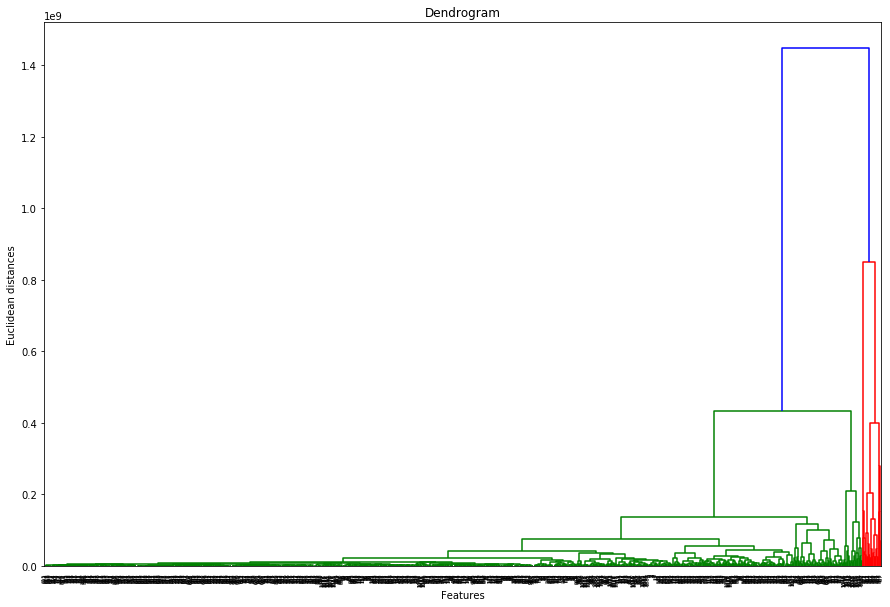

In [36]:
plt.figure(figsize=(15,10))
dendrogram = sch.dendrogram(sch.linkage(X, method  = "average"))
plt.title('Dendrogram')
plt.xlabel('Features')
plt.ylabel('Euclidean distances')
plt.show()

In [37]:
hc = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage ='ward') ###use; average, complete and singular methods
y_hc=hc.fit_predict(X)

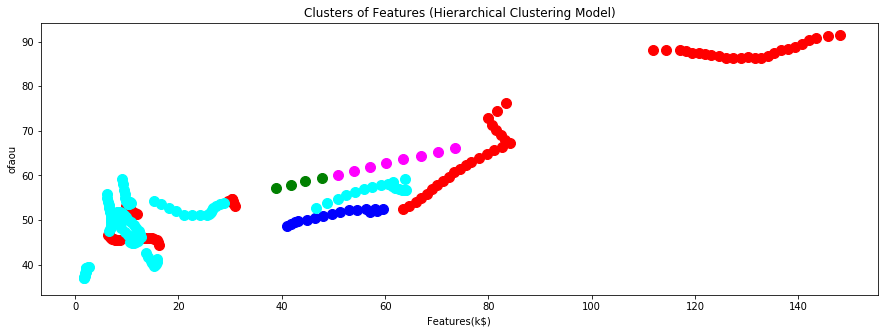

In [38]:
plt.figure(figsize=(15,5))
plt.scatter(X[y_hc==0, 0], X[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_hc==1, 0], X[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_hc==2, 0], X[y_hc==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y_hc==3, 0], X[y_hc==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y_hc==4, 0], X[y_hc==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.title('Clusters of Features (Hierarchical Clustering Model)')
plt.xlabel('Features(k$)')
plt.ylabel('ofaou')
plt.show()

In [39]:
#FOR CLUSTERING OF COUNTRIES (LOWER THRESHOLD REQUIRED TO OBTAIN MORE DATA)
processed_attributes , n_years= create_df(0.3, 0.85, 1990,2015)
country_list = get_country_list(processed_attributes)
a = impute_a(processed_attributes,range(0,len(country_list)))
data_final = pd.concat(a)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_final)
data_scaled = pd.DataFrame(data_scaled, columns=data_final.columns)
pcamodel = PCA(n_components=10)
pca = pcamodel.fit_transform(data_scaled)

Adding ARG 0.4833035714285714
Adding AUS 0.4632440476190476
Adding AUT 0.4811607142857143
Adding BEL 0.463125
Adding CAN 0.4529761904761904
Adding CZE 0.49872023809523813
Adding DNK 0.4911011904761905
Adding ECU 0.6455654761904762
Adding EST 0.45895833333333336
Adding FIN 0.4933630952380952
Adding FRA 0.48684523809523805
Adding DEU 0.4795238095238096
Adding GRC 0.47627976190476196
Adding HKG 0.38592261904761904
Adding HUN 0.5111011904761904
Adding ISL 0.4392559523809524
Adding IND 0.6361309523809524
Adding IRL 0.47901785714285716
Adding ISR 0.43875
Adding ITA 0.4899404761904762
Adding KOR 0.5043154761904762
Adding LVA 0.45116071428571425
Adding LTU 0.4419047619047619
Adding LUX 0.41770833333333335
Adding MEX 0.6895238095238095
Adding NLD 0.4805952380952381
Adding NZL 0.43675595238095233
Adding NGA 0.5913690476190476
Adding NOR 0.47413690476190473
Adding POL 0.4951488095238096
Adding PRT 0.4770833333333333
Adding RWA 0.5667559523809524
Adding SGP 0.4202678571428572
Adding SVK 0.46220238

In [42]:
pd.isna(data_final).sum().sum()

0

In [43]:
#MAP PCA to their variables
comps = pd.DataFrame(pcamodel.components_, columns = data_final.columns)
n_pcs= pcamodel.n_components_  # get number of component

CREATE DATAFRAME OF THE CORRELATION OF VARIABLES WITH THE FIRST 10 PCA's

In [44]:
#FIRST 10 PCA'S AND HOW MUCH EACH FEAUTRE IS CORRELATED WITH THE PCA
comps.index = [f"PCA {i}" for i in range(1,11)]
comps

,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DKAP.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.AEDU.GN.ZS,NY.ADJ.AEDU.CD,NY.ADJ.DNGY.GN.ZS,NY.ADJ.DNGY.CD,NY.ADJ.ICTR.GN.ZS,NY.ADJ.DMIN.GN.ZS,...,SL.EMP.TOTL.SP.ZS,SL.EMP.1524.SP.FE.ZS,SL.EMP.1524.SP.MA.ZS,SL.EMP.1524.SP.ZS,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.1524.ZS
PCA 1,-0.013257,0.099979,0.035754,0.105258,0.023836,0.104736,-0.018255,0.075557,0.015809,-0.018412,...,-0.030362,-0.010843,-0.016026,-0.013794,-0.006271,-0.005624,-0.006170,-0.002800,0.002675,-0.000051
PCA 2,0.028328,0.063578,-0.078057,0.047878,-0.062956,0.048120,0.031911,0.049076,-0.042162,0.031555,...,0.070592,0.039435,0.051605,0.046984,-0.024277,-0.019668,-0.022389,-0.031678,-0.030526,-0.031916
PCA 3,0.007995,-0.025997,0.020570,-0.030617,-0.011144,-0.034142,-0.008846,-0.032561,0.046621,-0.006316,...,-0.003806,-0.019509,-0.034466,-0.027753,-0.020414,-0.018530,-0.020012,-0.014602,-0.012046,-0.013879
PCA 4,0.132072,0.015999,-0.002708,-0.012905,-0.039221,-0.013296,0.020794,-0.011132,-0.020485,-0.010334,...,-0.145319,-0.156753,-0.109853,-0.138424,0.114485,0.094522,0.106808,0.115963,0.101105,0.110666
PCA 5,0.001236,-0.002698,-0.071254,-0.025087,-0.075877,-0.024618,0.043597,0.013235,0.132056,-0.001789,...,0.024000,0.004220,0.033032,0.019003,-0.095864,-0.102537,-0.103263,-0.085419,-0.097533,-0.094028
PCA 6,-0.022253,-0.003622,-0.021836,0.026826,-0.070949,0.023999,-0.019155,-0.010255,-0.032011,0.045002,...,-0.045512,-0.065549,-0.122817,-0.096755,0.100400,0.111136,0.110361,0.104903,0.110500,0.110581
PCA 7,0.038497,0.015621,-0.004317,0.005749,-0.006482,0.006483,-0.122141,-0.027917,0.003733,-0.079377,...,0.044401,0.038497,0.041404,0.041155,-0.049384,-0.066355,-0.060339,-0.063697,-0.084218,-0.075602
PCA 8,-0.095757,-0.021900,-0.010823,-0.000804,-0.009093,-0.006569,-0.091185,-0.058845,-0.040374,-0.099647,...,0.009552,-0.009826,-0.005905,-0.007584,-0.058603,-0.082810,-0.074481,-0.039966,-0.056494,-0.049117
PCA 9,-0.039584,-0.015314,-0.086167,0.016089,-0.057487,0.016842,0.196283,0.048470,-0.036006,-0.149553,...,-0.040847,-0.025364,-0.005506,-0.017081,-0.054270,-0.086582,-0.075390,-0.059670,-0.084628,-0.074978
PCA 10,-0.032406,-0.009092,-0.061547,-0.022085,0.062654,-0.017757,-0.016802,0.008756,-0.121535,-0.042029,...,0.007695,0.036529,0.068260,0.053390,0.028141,-0.024529,-0.001728,0.029781,-0.005160,0.010030


In [45]:
#BELOW, I WILL FIND THE NUMBER FEATURES ABOVE A CERTAIN ABSOLUTE CORRELATION 
#THRESHOLD FOR THE FIRS 2 PCAS. #I'M AIMING FOR A NUMBER SMALL ENOUGH THAT THE 
#DTW RUNS QUICKLY, BUT LARGE ENOUGH THAT I GET GOOD RESULTS.

#CONDITION TO HELP ME REMOVE COLUMNS 
def makena(x):
  if x == False:
    return(np.nan)
  else:
    return True
def find_influential(n_pca,threshold):
  comp_bool = (abs(comps)>threshold)[0:n_pca]
  comp_bool = comp_bool.applymap(makena)
  comp_bool.dropna(thresh=2,axis=1,inplace=True)
  influential = comp_bool.columns
  print(f"{len(influential)} indicators selected")
  return (influential)
influential = find_influential(2,0.055)

50 indicators selected


CLUSTERING


NORMALIZATION, SCALING AND GROUPING BY COUNTRY

In [46]:
ind_dist_mat = 1-abs(processed_attributes[influential].corr())

In [47]:
#list(indicators_countries[indicators_countries["IndicatorCode"].isin(influential)]["IndicatorName"])

In [48]:
#Determine the number of countries were working with
n_countries = len(a)

In [49]:
#Filter selected features from scaled dataframe and assign to variable
clustering_df_pre = data_scaled[influential]
n_years = n_years 
#Create list where each index is the dataframe containing the multivariate time 
#series for each country
clustering_df = []
for i in range(n_countries):
  clustering_df.append(clustering_df_pre[(n_years)*i: (n_years)*(i+1)])

In [50]:
#VECTORIZED IMPLEMENTATION OF THE DTW ALGORITHM. 
#c1 = country 1, c2 = country2
#1. PERFORM DTW between indicatorA (c1) and indicatorA(c2)
#to compute total distance between indicators (scalar (x_n))
#2. APPLY over time all time series between country1 and country2 to 
# to obtain vector v(x_1,x_2,x_3)
#3. FIND mean of resultant vector M_c1_c2 (this is the distance between c1 & c2)
#4. Repeat for all combinations of c_i & c_j where i != j

#BETWEEN THE DISSIMILARITY BETWEEN THE SET OF TIME SERIES FOR ONE COUNTRY AND THE SET 
#OF TIME SERIES FOR ANOTHER. IT MAY BE USEFUL TO WRITE THE PSEUDOCODE IN LATEX
#FOR EASY COMPREHENSION.
def total_dtw(x,y):
  return (list(map(lambda a, b : fastdtw(a, b, dist=euclidean)[0],x,y)))
def get_distances(i, offset, df_table):
  ts1 = np.array(df_table[i][::offset].transpose())
  if offset >1:
      return list(map(lambda b: np.mean(total_dtw(ts1,np.array(df_table[b][::offset].transpose()))), range(i+1,len(clustering_df))))
  else:
      return list(map(lambda b: np.mean(total_dtw(ts1,np.array(df_table[b][::offset].transpose()))), range(i+1,len(clustering_df))))
res = list(map(lambda x: get_distances(x, 10, clustering_df), range(0,len(clustering_df))))
#takes up to 80 seconds on colab so give it time

In [51]:
import numpy as np
zero_mat = np.zeros([len(res),len(res)])
for i in range(len(zero_mat)):
  zero_mat[i,i+1:] = res[i]

In [52]:
#VISUALIZE DISTANCE MATRIX
dist_mat = np.array(zero_mat) + np.array(zero_mat).transpose()
dist_mat = pd.DataFrame(dist_mat/np.max(dist_mat))
np.mean(np.max(dist_mat))
dist_mat.columns = country_list
dist_mat.index = country_list
ind_dist_mat = processed_attributes[influential].corr()
ind_dist_mat = np.abs(ind_dist_mat)

In [53]:
from sklearn.cluster import AgglomerativeClustering
def cluster(dist_mat, thresh):
  cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', distance_threshold=thresh)
  prediction = cluster.fit_predict(dist_mat)
  return (prediction)
names = country_list
def get_c_dict(dist_mat, prediction,names):
  c_dict = {}
  names = dist_mat.columns
  for i in range(dist_mat.shape[0]):
    try:
      c_dict[prediction[i]].append(names[i])
    except:
      c_dict.update({prediction[i]:[names[i]]})
  return c_dict
c_pred = cluster(dist_mat, 0.95)
c_dict_ind = cluster(ind_dist_mat, 1.2)
c_dict=get_c_dict(dist_mat,c_pred, names)
c_dict_ind = get_c_dict(ind_dist_mat, c_dict_ind, ind_dist_mat.columns)


In [54]:
c_dict_ind

{1: ['NY.ADJ.DCO2.CD',
  'AG.PRD.CREL.MT',
  'EN.ATM.CO2E.KT',
  'EN.ATM.CO2E.LF.KT',
  'EN.ATM.CO2E.SF.KT',
  'NY.GDP.MKTP.PP.KD',
  'NY.GDP.MKTP.PP.CD',
  'NY.GNP.MKTP.PP.CD',
  'NE.CON.PRVT.PP.CD',
  'NE.CON.PRVT.PP.KD'],
 0: ['SP.POP.DPND',
  'SP.POP.DPND.YG',
  'NV.AGR.TOTL.ZS',
  'SP.DYN.CBRT.IN',
  'SP.DYN.TFRT.IN',
  'SH.MMR.RISK.ZS',
  'SH.STA.MMRT',
  'SP.DYN.IMRT.IN',
  'SH.DYN.NMRT',
  'SH.DYN.MORT',
  'SP.POP.0014.TO.ZS',
  'SP.POP.1564.TO.ZS',
  'SH.ANM.CHLD.ZS'],
 3: ['AG.LND.AGRI.K2', 'EN.URB.LCTY'],
 8: ['NV.AGR.TOTL.KD',
  'NV.AGR.TOTL.CD',
  'AG.LND.ARBL.HA',
  'MS.MIL.TOTL.P1',
  'SP.URB.TOTL'],
 6: ['EN.ATM.CO2E.PC'],
 4: ['SL.SRV.EMPL.ZS',
  'NY.GNP.PCAP.CD',
  'NE.CON.PRVT.PC.KD',
  'NY.GDP.PCAP.PP.KD',
  'NY.GDP.PCAP.PP.CD',
  'NY.GNP.PCAP.PP.CD'],
 2: ['IT.MLT.MAIN.P2', 'SL.GDP.PCAP.EM.KD', 'SH.ANM.NPRG.ZS', 'SH.PRG.ANEM'],
 5: ['NY.GDP.FRST.RT.ZS', 'EG.FEC.RNEW.ZS'],
 7: ['SP.DYN.LE00.FE.IN',
  'SP.DYN.LE00.MA.IN',
  'SP.DYN.LE00.IN',
  'SP.DYN.AMRT.FE',
  'SP

In [55]:
c_dict

{1: ['ARG', 'ECU', 'MEX', 'ZAF'],
 0: ['AUS',
  'AUT',
  'BEL',
  'CAN',
  'CHE',
  'CZE',
  'DEU',
  'DNK',
  'ESP',
  'FIN',
  'FRA',
  'GBR',
  'GRC',
  'HKG',
  'IRL',
  'ISL',
  'ISR',
  'ITA',
  'KOR',
  'LUX',
  'NLD',
  'NOR',
  'NZL',
  'PRT',
  'SGP',
  'SVN',
  'SWE'],
 2: ['EST', 'HUN', 'LTU', 'LVA', 'POL', 'SVK'],
 4: ['IND'],
 3: ['NGA', 'RWA', 'TZA', 'UGA', 'ZMB'],
 5: ['USA']}

Try multiple linkages of agglomerative heirarchical clustering.

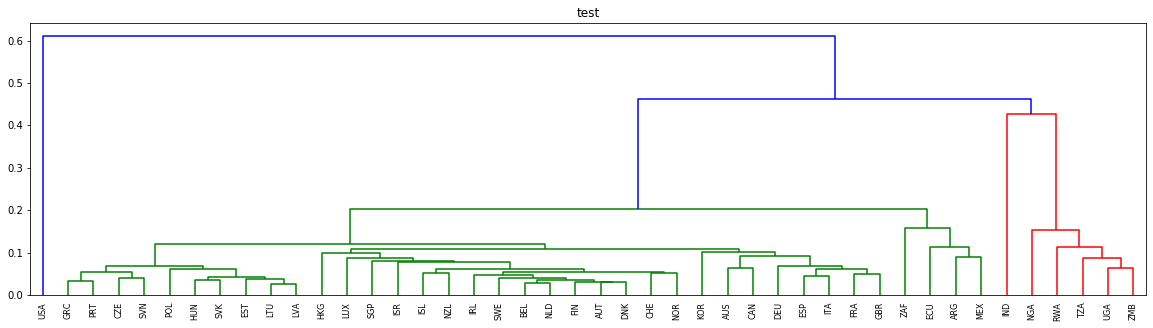

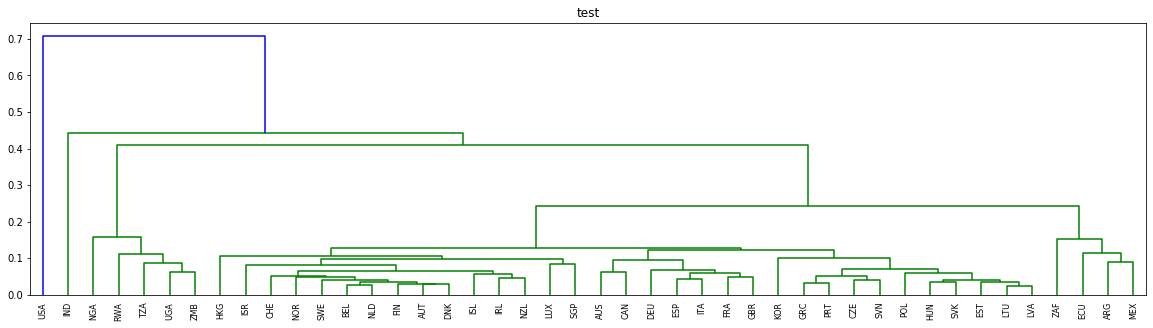

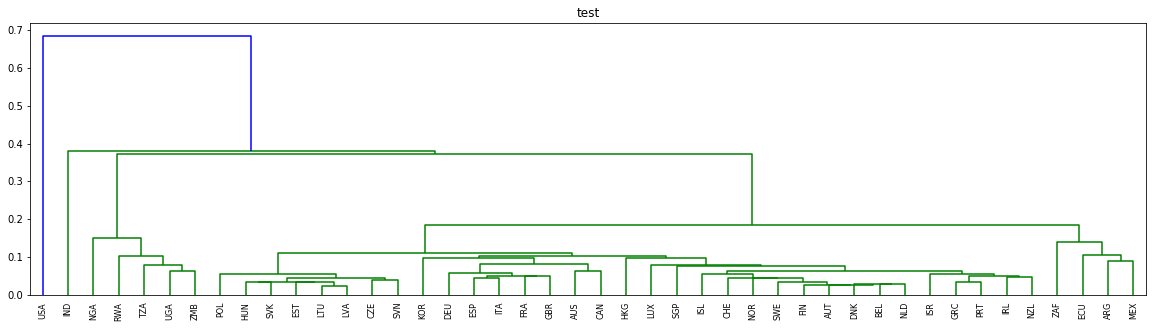

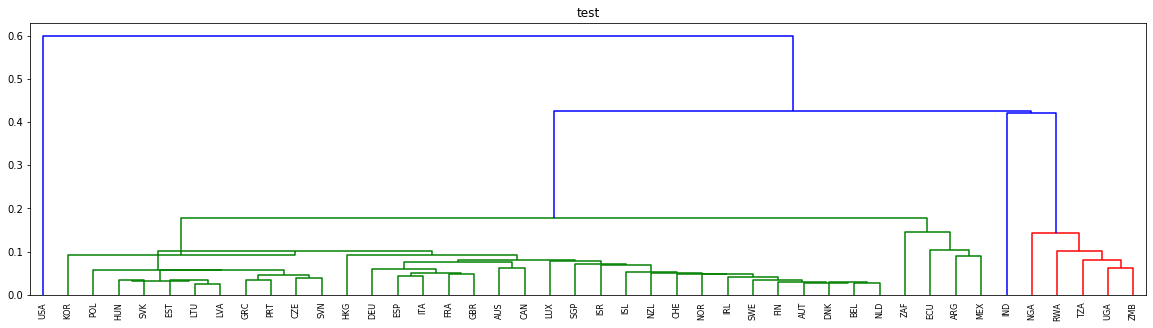

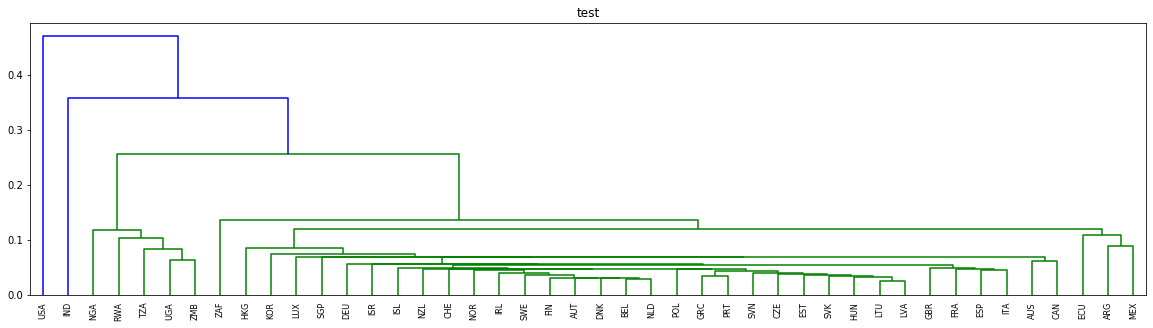

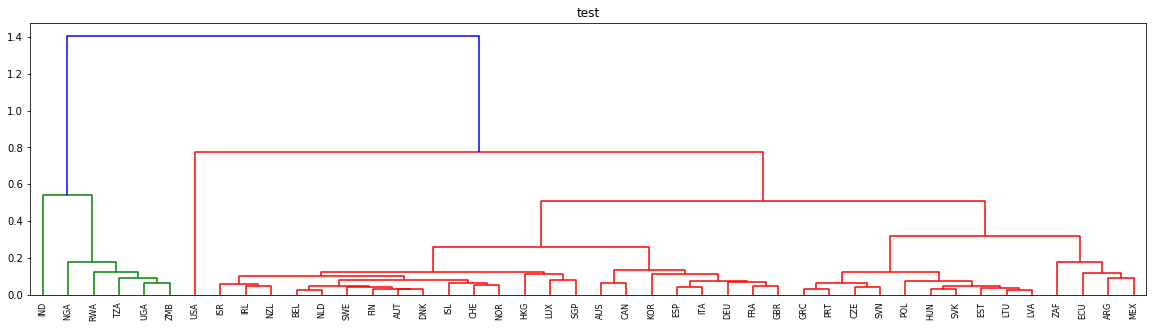

In [56]:
#CREATE DICTIONARY OF KEY = COUNTRIES AND THEIR VALUE =CLUSTER 
#(MAY BE USEFUL LATER ON )
a = pd.DataFrame(pd.Series(c_dict))
a.reset_index(inplace = True)
names = []
n_clusters = 6
for i in range(n_clusters):
  names.append(list(a[a[0] == i]['index'].values))

#ENSURE THAT DISTANCE MATRIX IS SYMMETRICAL (PREREQUISITE FOR AGG-HEIR)
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
check_symmetric(dist_mat)

#PLOT DENDOGRAM (CLUSTERING FINITO)
methods = ["average", "weighted", "median", "centroid", "single", "ward"]
dists = squareform(dist_mat)
for method in methods:
  linkage_matrix = linkage(dists, method)
  plt.figure(figsize = (20,5))
  dendrogram = sch.dendrogram(linkage_matrix, labels = country_list)
  plt.title("test")
  plt.show()  

In [57]:
initial_medoids = [1,2,3,4,5,6]
kmedoids_instance = kmedoids(np.array(dist_mat),initial_medoids,data_type='distance_matrix')
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
c_list = list(map(lambda x: list(np.array(country_list)[np.array(x)]),clusters))
c_dict = dict(zip(range(0,6),c_list))
c_dict

{0: ['USA'],
 1: ['AUS',
  'AUT',
  'BEL',
  'CAN',
  'CHE',
  'DEU',
  'DNK',
  'ESP',
  'FIN',
  'FRA',
  'GBR',
  'GRC',
  'HKG',
  'IRL',
  'ISL',
  'ISR',
  'ITA',
  'LUX',
  'NLD',
  'NOR',
  'NZL',
  'SGP',
  'SWE'],
 2: ['IND'],
 3: ['ARG', 'ECU', 'MEX', 'ZAF'],
 4: ['NGA', 'RWA', 'TZA', 'UGA', 'ZMB'],
 5: ['CZE', 'EST', 'HUN', 'KOR', 'LTU', 'LVA', 'POL', 'PRT', 'SVK', 'SVN']}

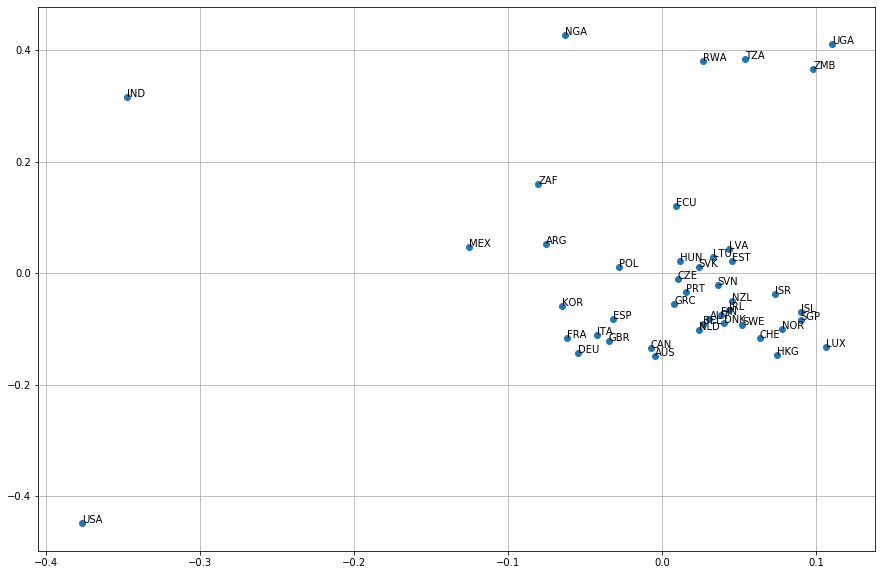

In [58]:
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
mds_fit = mds_model.fit(np.array(dist_mat))  
mds_coords = mds_model.fit_transform(np.array(dist_mat))
plt.figure( figsize = (15,10))
plt.scatter(mds_coords[:,0],mds_coords[:,1])
for j in range(mds_coords.shape[0]):
  plt.annotate(country_list[j], (mds_coords[j,0],mds_coords[j,1]), fontsize = 10)
plt.grid()
zip(mds_coords)

In [59]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 6)
prediction = model.fit(mds_coords)
prediction = prediction.labels_
c_dict = {}
names = country_list
get_c_dict(dist_mat,prediction, names)

{2: ['ARG',
  'CZE',
  'ECU',
  'EST',
  'HUN',
  'LTU',
  'LVA',
  'MEX',
  'POL',
  'SVK',
  'ZAF'],
 0: ['AUS', 'CAN', 'DEU', 'ESP', 'FRA', 'GBR', 'ITA', 'KOR'],
 5: ['AUT',
  'BEL',
  'CHE',
  'DNK',
  'FIN',
  'GRC',
  'HKG',
  'IRL',
  'ISL',
  'ISR',
  'LUX',
  'NLD',
  'NOR',
  'NZL',
  'PRT',
  'SGP',
  'SVN',
  'SWE'],
 4: ['IND'],
 1: ['NGA', 'RWA', 'TZA', 'UGA', 'ZMB'],
 3: ['USA']}

In [60]:
processed_attributes , n_years= create_df(0.3, 0.8, 1960,2015)
country_list = get_country_list(processed_attributes)
a = impute_a(processed_attributes,range(0,len(country_list)))
data_final = pd.concat(a)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_final)
data_scaled = pd.DataFrame(data_scaled, columns=data_final.columns)

Adding ARG 0.350392316017316
Adding AUS 0.3419237012987013
Adding AUT 0.34450757575757573
Adding BEL 0.31670725108225106
Adding CAN 0.33256222943722946
Skipping CZE 0.2584686147186147
Adding DNK 0.3449810606060606
Adding ECU 0.483103354978355
Skipping EST 0.2291801948051948
Adding FIN 0.35238095238095235
Adding FRA 0.3561011904761905
Adding DEU 0.3127299783549784
Adding GRC 0.3482683982683983
Skipping HKG 0.2756087662337663
Adding HUN 0.30086580086580084
Skipping ISL 0.29894480519480515
Adding IND 0.48221049783549785
Adding IRL 0.3337797619047619
Adding ISR 0.3044778138528138
Adding ITA 0.35292207792207797
Adding KOR 0.3798701298701299
Skipping LVA 0.22474296536796534
Skipping LTU 0.22031926406926405
Skipping LUX 0.28118235930735935
Adding MEX 0.5028138528138528
Adding NLD 0.35576298701298703
Adding NZL 0.31124188311688317
Adding NGA 0.42349837662337664
Adding NOR 0.3432900432900433
Skipping POL 0.2857548701298701
Adding PRT 0.3393668831168831
Adding RWA 0.4287472943722944
Adding SGP 0

In [61]:
pd.isna(data_final).sum().sum()

0

In [62]:
data_scaled

,SP.ADO.TFRT,SP.POP.DPND,SP.POP.DPND.OL,SP.POP.DPND.YG,MS.MIL.MPRT.KD,SP.DYN.CBRT.IN,NE.GDI.STKB.CN,EN.ATM.CO2E.KD.GD,EN.ATM.CO2E.KT,EN.ATM.CO2E.PC,...,TX.VAL.MANF.ZS.UN,TM.VAL.MANF.ZS.UN,TX.VAL.MMTL.ZS.UN,TM.VAL.MMTL.ZS.UN,NY.ADJ.DNGY.CD,NY.ADJ.DMIN.CD,SE.SEC.AGES,SE.PRM.AGES,SE.PRM.DURS,SE.SEC.DURS
0,0.252663,-0.327262,-0.937695,0.045646,-0.437726,0.168376,-0.057676,0.363656,-0.312936,-0.897771,...,-0.933166,0.821259,-0.390128,0.308303,0.068704,-0.110811,0.587467,-0.314472,0.924842,-1.01201
1,0.249774,-0.316641,-0.905917,0.043747,-0.243410,0.150679,-0.057676,0.354260,-0.310049,-0.882233,...,-0.933166,0.821259,-0.390128,0.308303,0.068704,-0.110811,0.587467,-0.314472,0.924842,-1.01201
2,0.246885,-0.310203,-0.875573,0.039153,-0.542505,0.133459,-0.057676,0.452619,-0.306978,-0.865737,...,-1.646925,1.024835,-0.460061,-0.428580,0.068704,-0.110811,0.587467,-0.314472,0.924842,-1.01201
3,0.244001,-0.307981,-0.846204,0.031697,-0.597752,0.117270,-0.057676,0.425813,-0.311387,-0.908341,...,-1.571326,0.848764,-0.458745,0.103935,0.068704,-0.110811,0.587467,-0.314472,0.924842,-1.01201
4,0.241116,-0.309938,-0.817186,0.021213,-0.597752,0.102907,-0.057676,0.444023,-0.304499,-0.862431,...,-1.519203,-0.035255,-0.480177,1.563897,0.068704,-0.110811,0.587467,-0.314472,0.924842,-1.01201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,1.272526,1.994218,-1.344811,1.914702,-0.631408,1.614804,-0.055426,-0.775319,-0.369255,-1.347588,...,-1.552512,-0.547642,5.012302,7.532793,-0.346728,0.584277,1.983121,1.508038,1.368115,-1.41822
1866,1.195433,1.977628,-1.344542,1.902165,-0.632043,1.575602,-0.055426,-0.734914,-0.368798,-1.343376,...,-1.427842,0.088191,4.672404,6.023585,-0.346727,0.730896,1.983121,1.508038,1.368115,-1.41822
1867,1.118341,1.951202,-1.345343,1.882577,-0.508214,1.536956,-0.055426,-0.734914,-0.368798,-1.343376,...,-1.369768,0.017325,4.207672,4.724535,-0.346615,0.663008,1.983121,1.508038,1.368115,-1.41822
1868,1.011906,1.917664,-1.347457,1.858060,-0.508214,1.500690,-0.055426,-0.734914,-0.368798,-1.343376,...,-1.230160,-0.088586,3.954276,5.847379,-0.346340,0.722964,1.983121,1.508038,1.368115,-1.41822


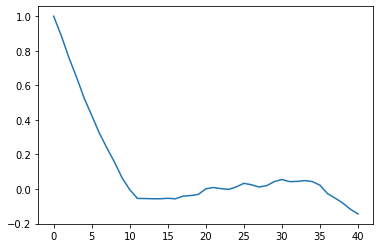

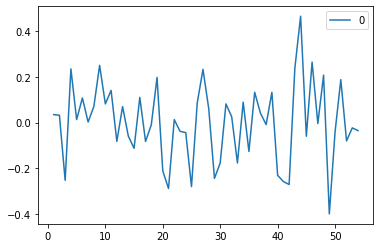

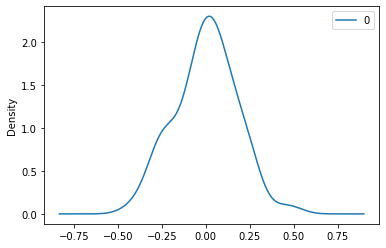

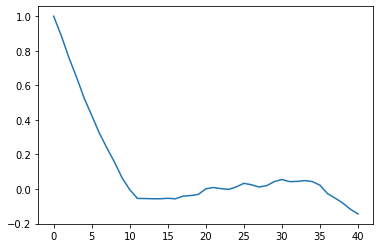

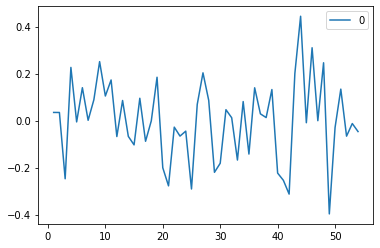

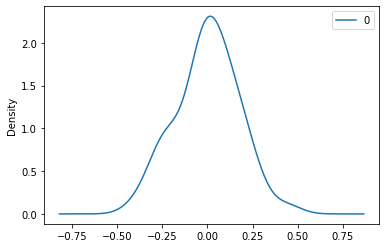

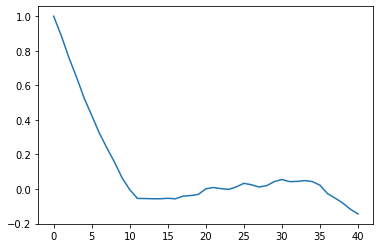

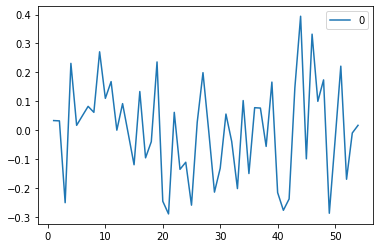

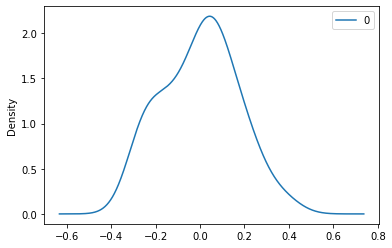

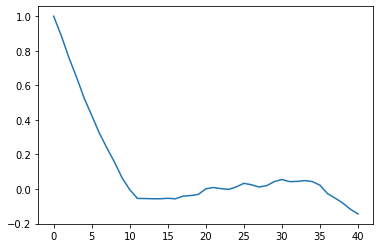

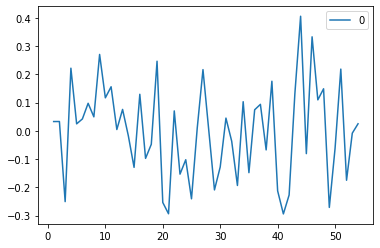

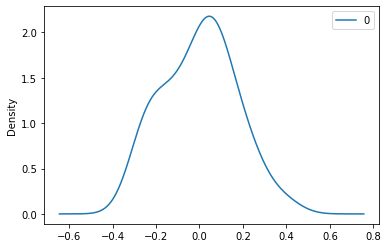

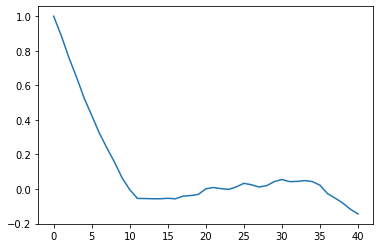

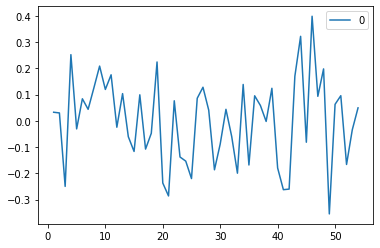

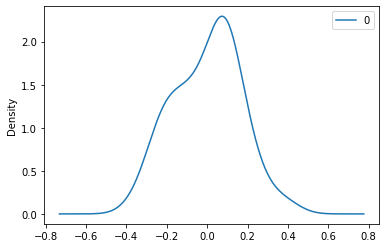

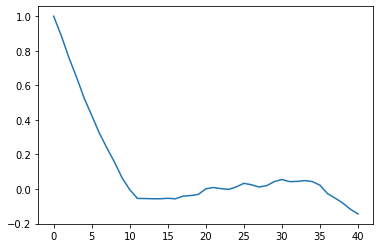

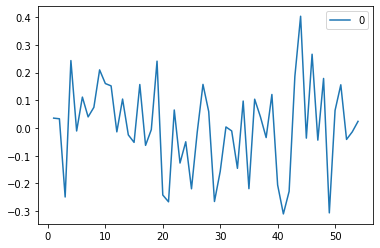

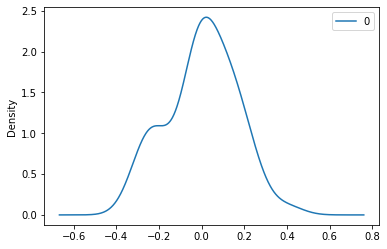

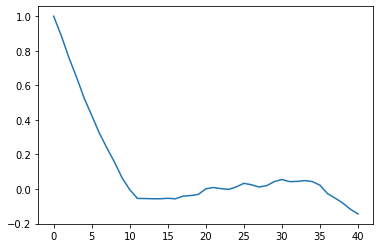

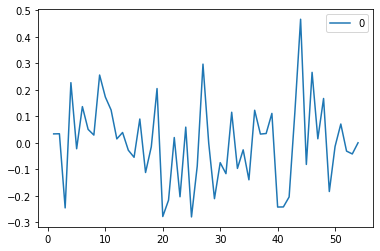

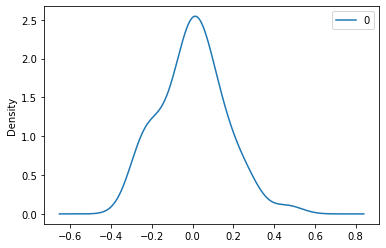

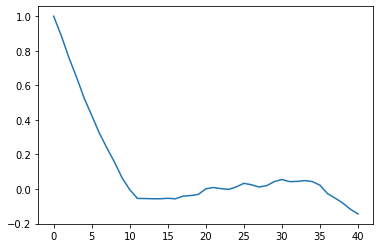

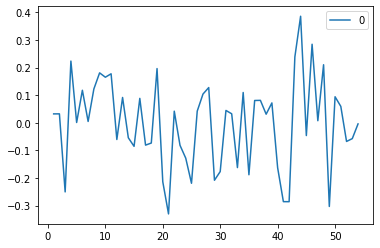

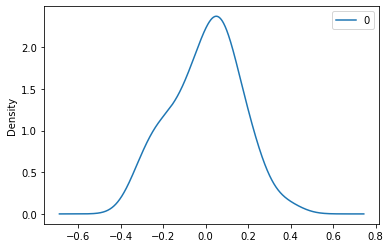

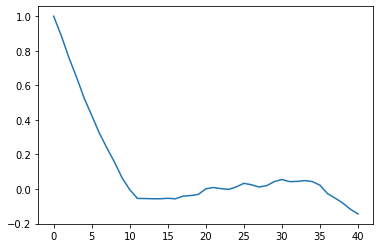

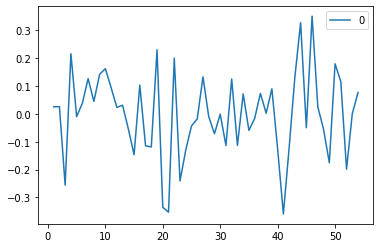

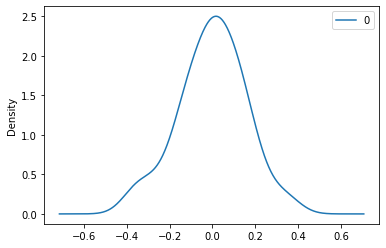

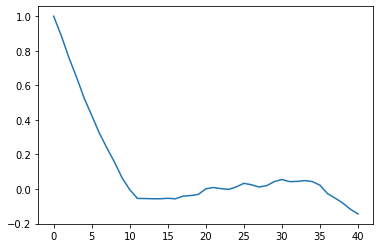

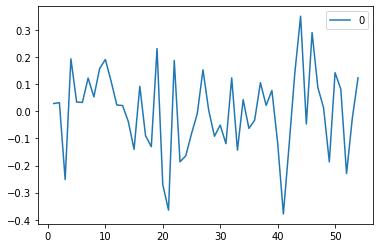

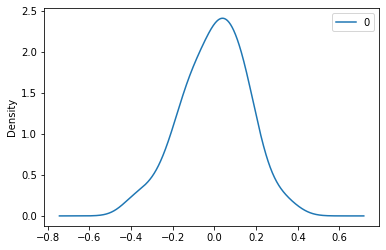

0 1 11
predicted=3.591189, expected=3.648190
predicted=3.686441, expected=3.758387
predicted=3.729253, expected=3.798782
predicted=3.765870, expected=3.969876
predicted=3.843849, expected=3.806976
predicted=3.890681, expected=3.539533
predicted=3.601176, expected=3.253313
predicted=3.269685, expected=3.475035
predicted=3.672756, expected=4.032407
predicted=nan, expected=4.111635
predicted=nan, expected=4.404525
predicted=4.366727, expected=4.496834
predicted=4.427917, expected=4.744178
predicted=4.612325, expected=4.427960
predicted=4.074389, expected=4.342272
predicted=nan, expected=4.562049
predicted=4.897518, expected=4.562049
predicted=4.528568, expected=4.562049
predicted=4.508739, expected=4.562049
Test MSE: nan
Test MAPE: nan


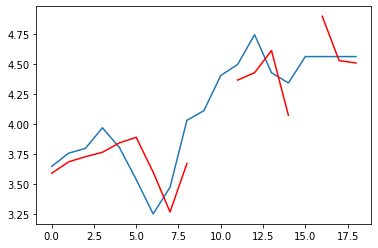

In [63]:
idx = 9
q = 1
d = 1
i = 0
vv = True
while vv ==  True and i <10:
	#data = data_scaled[0:n_years].iloc[:,idx]
	data = data_final[0:n_years].iloc[:,idx]
	try:
		p = np.where(acf(data)>0.9)[0][-1]
		plt.plot(acf(data))
		model= ARIMA(data, (p,d,q))
		model_fit = model.fit(disp = 0, const = 'c')
		residuals = pd.DataFrame(pd.Series(model_fit.resid))
		residuals.plot()
		plt.show()
		residuals.plot(kind='kde')
		plt.show()
		adfuller(series)[0]
		vv = False
	except: 
		if (d < 1):
			d += 1
		else:
			q +=1
	i += 1



print(p,d,q)

series = data_final[0:n_years].iloc[:,idx]
ex = data_final[0:n_years].iloc[:,1]
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
trainexog, testexog = ex[0:size], ex[size:len(ex)]
history = [x for x in train]
exog = [x for x in trainexog]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(p,d,q))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
mse = np.mean(np.abs(np.array(test) -  np.array(predictions)))
mape = np.mean(np.abs((np.array(test) -  np.array(predictions))/np.array(predictions)))
print('Test MSE: %.3f' % mse)
print('Test MAPE: %.3f' % mape)
plt.plot(test)
plt.plot(predictions, color='red')

In [64]:
data_final.index = processed_attributes.index
data_final_country = data_final[np.in1d(data_final.index.get_level_values(0), ['USA'])]

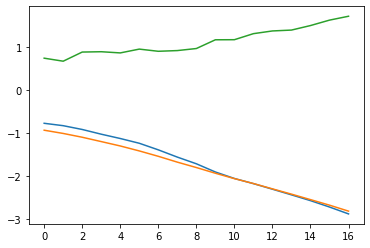

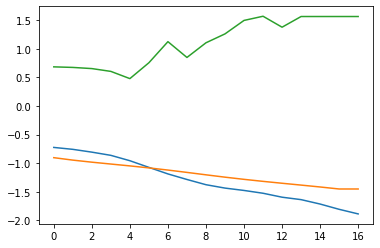

In [65]:
data_final.index = processed_attributes.index
data_final_country = data_final[np.in1d(data_final.index.get_level_values(0), ['USA'])]
sel_cols = np.where(data_final_country.columns.map(lambda x: x in influential))
data_final_country = data_final_country.iloc[:,sel_cols[0]]
data_final_country1 = np.abs(data_final_country.corr())>0.8
data_final_country1 = data_final_country1.applymap(makena)
data_final_country1.dropna(thresh = 10, axis=1, inplace=True)
dd = data_final_country[data_final_country1.columns]
n_years = data_final_country.shape[0]

dd = np.array(dd.iloc[:,1:4]).reshape(n_years,3)
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(dd))
scaler.inverse_transform(data_scaled)
vunscaled = dd[int(0.3*(len(dd))):]

#creating the train and validation set
train = data_scaled[:int(0.7*(len(data_scaled)))]
valid = data_scaled[int(0.7*(len(data_scaled))):]

#fit the model
model = VAR(endog=train)
model.select_order
model_fit = model.fit(maxlags = 30, trend = 'ctt')

# make prediction on validation
prediction = model_fit.forecast(model_fit.y,steps=len(valid))
plt.plot(prediction)
plt.show()
plt.plot(np.array(valid))
plt.show()

In [66]:
pred_df = pd.DataFrame(prediction)
valid_df =  pd.DataFrame(valid).reset_index().drop('index',1) #index columns did not match
np.mean((np.abs(pred_df - valid_df)/np.abs(valid_df)).mean(1))

0.320283046434908

### SVM 

In [67]:
columns = ['SP.POP.0014.TO.ZS','SP.POP.DPND.YG','SP.POP.DPND','SP.POP.TOTL','SP.RUR.TOTL','SP.RUR.TOTL.ZS','SP.POP.TOTL.FE.ZS','PA.NUS.ATLS','SP.POP.GROW']
data_interest = pd.DataFrame(data_final, columns=columns)


data_argentina = data_interest.iloc[:,] 
data_arg = data_argentina[0:54]
data_arg_train = data_arg[['SP.POP.0014.TO.ZS','SP.POP.TOTL','SP.RUR.TOTL']]

year_argentina = list(map(lambda x: x[1], data_arg_train.index))
feature_arg = data_arg['SP.POP.0014.TO.ZS'].values


In [68]:
X = np.asmatrix(year_argentina).reshape(-1,1)
Y = np.asmatrix(feature_arg).reshape(-1,1)
X_train = X[0:35]
X_test = X[36:]
y_train = Y[0:35]
y_test = Y[36:]


In [69]:
svr_model = SVR(kernel= 'rbf', C= 1000, epsilon = 0.05, gamma= 0.001)
svr_model.fit(X_train,y_train)
y_pred = svr_model.predict(X_test)


### SVR Optimization

In [70]:

gsc = GridSearchCV(estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv = 5, scoring='neg_mean_squared_error', verbose=0)

grid_result = gsc.fit(X, Y)
best_params = grid_result.best_params_


In [71]:
best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)
best_svr.fit(X_train,y_train)
y_pred = best_svr.predict(X_test)


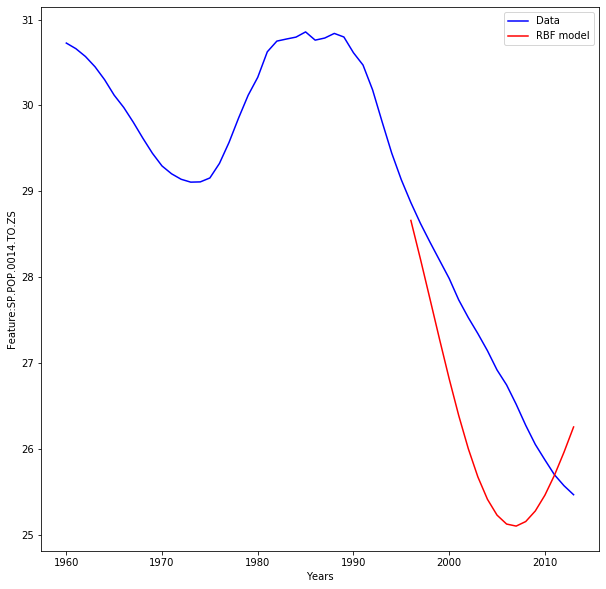

In [72]:
plt.figure(figsize = (10,10))
plt.plot(X, Y, color= 'blue', label= 'Data')
plt.plot(X_test,y_pred, color= 'red', label= 'RBF model') 
plt.xlabel('Years')
plt.ylabel('Feature:SP.POP.0014.TO.ZS')
plt.legend()
plt.show()

### Mean Squared Error for SVR

In [73]:
mse = mean_squared_error(y_test,y_pred)
mse

1.2827828962641137

### Mean Absolute Error for SVR

In [74]:
mae = mean_absolute_error(y_test,y_pred)
mae

0.9928602899819542

### LSTM 

In [75]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [76]:
df = pd.DataFrame(data = feature_arg,index = year_argentina,columns=['SP.POP.0014.TO.ZS'])

len(df) 
test_pecent = 0.3 # 30 percent of data
len(df)*test_pecent # 50.1
test_point = np.round(len(df)*test_pecent) # 50.0
test_index = int(len(df) - test_point) #451
train = df.iloc[:test_index]
test = df.iloc[test_index:]




In [77]:
n_features = 1
early_stop = EarlyStopping(monitor='val_loss',patience=2)
length = 15
batch_size = 6

generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=batch_size)

model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer = 'adam',loss='mae',metrics=['accuracy'])

model.fit_generator(generator,epochs=2,validation_data=validation_generator,callbacks=[early_stop])

NameError: name 'scaled_train' is not defined

In [78]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape(1,length,n_features)


for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

NameError: name 'scaled_train' is not defined

In [79]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

ValueError: operands could not be broadcast together with shapes (0,) (3,) (0,) 

### Forcast for full Data

In [80]:
full_scaler = MinMaxScaler()

scaled_full_data = full_scaler.fit_transform(df)

generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=batch_size)

model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))
#model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer = 'adam',loss='mae',metrics=['accuracy'])

model.fit_generator(generator = generator, epochs=0)

Instructions for updating:
Please use Model.fit, which supports generators.


In [81]:
forecast = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape(1,length,n_features)


for i in range(60):
  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

NameError: name 'scaled_train' is not defined

In [82]:
forecast = scaler.inverse_transform(forecast)

forecast_index = np.arange(1960,2020,step = 1)

plt.plot(df.index,df['SP.POP.0014.TO.ZS'])
plt.plot(forecast_index,forecast)

ValueError: operands could not be broadcast together with shapes (0,) (3,) (0,) 

## Time series forcast using random forest

-> actual=60.6, -> predicted=59.8
-> actual=60.8, -> predicted=60.3
-> actual=60.9, -> predicted=60.6
-> actual=61.0, -> predicted=60.8
-> actual=61.0, -> predicted=60.9
-> actual=61.2, -> predicted=61.0
-> actual=61.3, -> predicted=61.1
-> actual=61.6, -> predicted=61.2
-> actual=62.1, -> predicted=61.5
-> actual=62.5, -> predicted=61.8
-> actual=62.9, -> predicted=62.2
-> actual=63.2, -> predicted=62.7
-> actual=63.4, -> predicted=63.0
-> actual=63.5, -> predicted=63.2
-> actual=63.7, -> predicted=63.4
-> actual=64.0, -> predicted=63.6
-> actual=64.2, -> predicted=63.9
-> actual=64.6, -> predicted=64.1
-> actual=65.0, -> predicted=64.4
-> actual=65.4, -> predicted=64.8
MAE: 0.426
MAPE: 0.679
MSE: 0.218


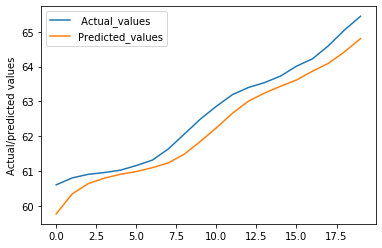

In [84]:
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
 
# create  a supervised learning dataset
def timeseries_supervised(value, input_steps=1, out_steps=1, dropnan=True):
    
    df = DataFrame(value)
    columns = [] 
    #put input sequence to a list
    for i in range(input_steps, 0, -1):
        columns.append(df.shift(i))  
    # put forcast sequence to alist
    for i in range(0, out_steps):
        columns.append(df.shift(-i))    
    concatnate = concat(columns, axis=1)
    # drop rows with NaN values
    if dropnan:
        concatnate.dropna(inplace=True)
    return concatnate.values
 
# split dataset into train/test sets
def split_train_test(data, test_num):
    return data[:-test_num, :], data[-test_num:, :]
 
# onr step prediction by fiting n random forest model 
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    
    # fit model 
   
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = split_train_test(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('-> actual=%.1f, -> predicted=%.1f' % (testy, yhat))
        # estimate prediction error
    mape=np.mean(np.abs((test[:, -1] - predictions) / test[:, -1])) * 100
    mse=mean_squared_error(test[:, -1], predictions)
    error = mean_absolute_error(test[:, -1], predictions)
    return error,mape,mse, test[:, -1], predictions
    
 
# load the dataset
data_final.index = processed_attributes.index
data_USA=data_final.loc['USA']

ts = pd.Series(data_USA['SP.POP.1564.TO.ZS'].values, index=data_USA.index)
df = pd.DataFrame({'time':ts.index, 'measure':ts.values})
df_time=df.set_index('time')
values = df_time.values

data = timeseries_supervised(values, 10,1)

# evaluate
mae,mape,mse, y, yhat = walk_forward_validation(data, 20)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
print('MSE: %.3f' % mse)
# plot expected vs predicted
pyplot.plot(y, label=' Actual_values')
pyplot.plot(yhat, label='Predicted_values')

pyplot.ylabel('Actual/predicted values')
pyplot.legend()
pyplot.show()

In [86]:
data_USA['SP.URB.GROW']

1960    3.411740
1961    3.507320
1962    3.039997
1963    2.792358
1964    2.613549
1965    2.492640
1966    2.418568
1967    2.381584
1968    2.372989
1969    2.384958
1970    2.391505
1971    2.431990
1972    2.416720
1973    2.389451
1974    2.356919
1975    2.325159
1976    2.285262
1977    2.229294
1978    2.232283
1979    2.321324
1980    2.487489
1981    2.773448
1982    2.845605
1983    2.902954
1984    2.933496
1985    3.173625
1986    3.638695
1987    3.560209
1988    3.437722
1989    3.274464
1990    3.063687
1991    3.049925
1992    3.003268
1993    3.018299
1994    3.035389
1995    3.050774
1996    3.104102
1997    3.161215
1998    3.214839
1999    3.270410
2000    3.324351
2001    2.881450
2002    2.327194
2003    2.208917
2004    2.225342
2005    2.237131
2006    2.252800
2007    2.268930
2008    2.287164
2009    2.299354
2010    2.316982
2011    2.333510
2012    2.352164
2013    2.358794
2014    2.372464
Name: SP.URB.GROW, dtype: float64